# Implementing an non-autoregressive Seq2Seq model using LSTM architecture

### About this notebook

This notebook was created as a deliverable for the group project under 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Group 17 - Cohort 01


## Define device for Torch - preferred CUDA for accelerated computation

In [455]:
# Matplotlib
import torch

# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


## Import train and test dataset

### Define load dataset function

In [456]:
import pandas as pd

def load_dataset(train_path, test_path):
    # Load and drop date column
    train_df = pd.read_csv(train_path, parse_dates=['date']).drop(columns=['date'])
    test_df = pd.read_csv(test_path, parse_dates=['date']).drop(columns=['date'])

    # Normalize using training statistics
    stats = train_df.describe().transpose()

    def normalize(df):
        return (df - stats["mean"]) / stats["std"]

    train_norm = normalize(train_df)
    test_norm = normalize(test_df)

    return train_norm, test_norm, stats

### Load train and test dataset

In [457]:
# Load dataset from file
train_file_path = '../dataset/train/DailyDelhiClimateTrain.csv'
test_file_path = '../dataset/test/DailyDelhiClimateTest.csv'
train_data, test_data, stats = load_dataset(train_file_path, test_file_path)

In [458]:
train_data[:5]

,meantemp,humidity,wind_speed,meanpressure
0,-2.108778,1.414955,-1.491189,0.025313
1,-2.462611,1.862191,-0.837909,0.037149
2,-2.494366,1.564034,-0.475464,0.041958
3,-2.290231,0.629806,-1.220816,0.033635
4,-2.653137,1.554095,-0.680070,0.029936


In [459]:
# number of samples in train dataset
len(train_data)

1462

## Define Pytorch Dataset and Dataloader objects

In [460]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

### Dataset object

In [461]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, n_inputs, n_outputs):
        self.dataframe = dataframe
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.inputs = []
        self.outputs = []
        self.define_samples()

    def define_samples(self):
        data_array = self.dataframe.values
        for i in range(len(data_array) - self.n_inputs - self.n_outputs):
            input_seq = data_array[i:i+self.n_inputs, :]         # Sequence length of 30, incl all features
            output_seq = data_array[i+self.n_inputs:i+self.n_inputs+self.n_outputs, :]  # Sequence length of 7, incl all features
            self.inputs.append(input_seq)
            self.outputs.append(output_seq)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)  # Shape: (n_inputs, 4)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32) # Shape: (n_outputs,)
        return x, y


In [462]:
n_inputs = 30
n_outputs = 7

train_dataset = CustomDataset(train_data, n_inputs, n_outputs)
test_dataset = CustomDataset(test_data, n_inputs, n_outputs)

In [463]:
train_dataset[0]

(tensor([[    -2.1088,      1.4150,     -1.4912,      0.0253],
         [    -2.4626,      1.8622,     -0.8379,      0.0371],
         [    -2.4944,      1.5640,     -0.4755,      0.0420],
         [    -2.2902,      0.6298,     -1.2208,      0.0336],
         [    -2.6531,      1.5541,     -0.6801,      0.0299],
         [    -2.5170,      1.3136,     -1.1667,      0.0383],
         [    -2.5170,      1.0631,     -0.1101,      0.0494],
         [    -2.2643,      0.1755,      0.0747,      0.0422],
         [    -1.5644,     -0.5678,      1.2491,      0.0327],
         [    -1.9727,      0.0732,      0.1310,      0.0253],
         [    -1.3311,     -0.5657,      0.8263,      0.0280],
         [    -1.5644,      0.7888,      1.4088,      0.0248],
         [    -1.3149,      0.8584,     -0.4755,      0.0124],
         [    -1.7232,      1.6336,     -1.3560,      0.0225],
         [    -1.4672,      0.6610,     -1.3753,      0.0264],
         [    -1.5871,      1.5442,     -1.4912,      0

### Dataloader Object

In [464]:
# Define batch size
batch_size = 128

# Random number generator (for reproducibility)
generator = torch.Generator()  # Defaults to CPU, which DataLoader expects

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Important: don't shuffle test data
    generator=generator
)

In [465]:
# Visualize a sample
sample = next(iter(train_dataloader))
input_sample, output_sample = sample
print("Input shape:", input_sample.shape)   
print("Output shape:", output_sample.shape) 


Input shape: torch.Size([128, 30, 4])
Output shape: torch.Size([128, 7, 4])


In [466]:
len(train_dataloader)

12

## Define Model Architecture

### Our encoder model

The EncoderLSTM below processes input sequences through an LSTM. It is designed to capture the temporal dependencies in the data.
Only the final hidden states are returned, encapsulating the learned representation of the entire sequence. This encoder can be used in sequence-to-sequence models, where its hidden state initializes the decoder to generate outputs based on the input sequence.

It uses several layers of LSTM and possibly dropout.

##### Define Encoder class

In [467]:
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn

In [468]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1, dropout = 0.0):
        super(EncoderLSTM, self).__init__() 
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            num_layers = num_layers, 
                            dropout = dropout if num_layers > 1 else 0.0, 
                            batch_first = False)

    def forward(self, input_seq):
        # For this encoder, we ignore the outputs if we only need the final hidden state(s)
        outputs, hidden = self.lstm(input_seq)
        return hidden

In [469]:
# Defining our EncoderRNN model
hidden_size = 64
encoder_model = EncoderLSTM(4, hidden_size)
print(encoder_model)

EncoderLSTM(
  (lstm): LSTM(4, 64)
)


#### Testing Encoder model

In [470]:
# Grab one batch from the train dataloader
inputs, _ = next(iter(train_dataloader))  # inputs shape: (batch_size, seq_len, input_size)

# Rearrange for GRU: (seq_len, batch_size, input_size)
inputs = inputs.permute(1, 0, 2)  # (seq_len, batch_size, input_size)

print("Input shape to encoder:", inputs.shape)  # Should be (seq_len, batch_size, 4)

# Pass through encoder
encoder_out = encoder_model(inputs)

print("Encoder output (last hidden state) shape:", encoder_out[0].shape)  # (1, batch_size, hidden_size)
print("Sample vector:", encoder_out[0])

Input shape to encoder: torch.Size([30, 128, 4])
Encoder output (last hidden state) shape: torch.Size([1, 128, 64])
Sample vector: tensor([[[ 0.0605,  0.1055, -0.0413,  ..., -0.0300,  0.0267,  0.0915],
         [ 0.0332, -0.1320,  0.0466,  ..., -0.1056, -0.0961, -0.0024],
         [ 0.0384,  0.0612,  0.0061,  ...,  0.0198, -0.0192,  0.0628],
         ...,
         [ 0.0567, -0.0465,  0.0312,  ..., -0.0639, -0.0949, -0.0043],
         [ 0.0772,  0.0769, -0.0160,  ..., -0.0533, -0.0346,  0.0293],
         [ 0.0432, -0.0029,  0.0277,  ...,  0.0025, -0.0698,  0.0184]]],
       grad_fn=<StackBackward0>)


### Our decoder model

The DecoderLSTM class is a PyTorch module designed to act as the decoder in a sequence-to-sequence architecture. It processes input sequences using an LSTM and then maps the LSTM outputs to the desired output space with a linear layer. It returns both the predicted output and the updated hidden state, making it suitable for sequential decoding in sequence-to-sequence tasks.

#### Define Decoder class

In [471]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, dropout = 0.0):
        super(DecoderLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.num_layers = num_layers
        
        self.output_size=output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            num_layers = num_layers, 
                            dropout = dropout if num_layers > 1 else 0.0, 
                            batch_first = False)
        
        self.linear = nn.Linear(hidden_size, self.output_size)

    def forward(self, input_seq, hidden,output_length,target=None):
        outputs = []
        decoder_input = input_seq 

        for i in range(output_length):
            # One step forward through LSTM
            decoder_output, hidden = self.lstm(decoder_input, hidden)
            
            decoder_output = self.linear(decoder_output)  
            outputs.append(decoder_output)

            if target is not None:
                decoder_input = input_seq 
            else:
                decoder_input = decoder_output.detach() 

        return torch.cat(outputs, dim=0)  # shape: (output_length, batch_size, 1)

In [472]:
# Defining our DecoderRNN model
decoder_model = DecoderLSTM(input_size=4,hidden_size = hidden_size, output_size= 4)
print(decoder_model)

DecoderLSTM(
  (lstm): LSTM(4, 64)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


#### Testing Decoder model

In [473]:
# Testing our DecoderRNN model

# Get a batch from dataloader
inputs, _ = next(iter(train_dataloader))  # inputs: (batch_size, seq_length, input_size)

# Permute for encoder: (seq_length, batch_size, input_size)
encoder_input = inputs.permute(1, 0, 2)

# Pass through encoder
encoder_hidden = encoder_model(encoder_input)  # shape: (1, batch_size, hidden_size)

# Initial decoder input: zeros, shape (1, batch_size, 1)
decoder_input = torch.zeros(1, inputs.size(0), 4).to(encoder_input.device)

# Run decoder
decoder_output = decoder_model(decoder_input, encoder_hidden, n_outputs)

# Output shape: (T_out, B, 1)
print("Decoder output shape:", decoder_output.shape)

Decoder output shape: torch.Size([7, 128, 4])


### Our Seq2Seq model

Assembling our encoder and decoder classes from earlier, the Seq2Seq class implements a sequence-to-sequence model using an encoder-decoder architecture. The encoder processes the input sequence to produce a final hidden state, which is then used as the starting point for the memory vector of the decoder. The decoder is then responsible for generating the output sequence.

#### Define Seq2Seq class

In [474]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, hidden_size, input_size, output_size,output_length,num_layers=1):
        super(Seq2SeqLSTM, self).__init__()
        
        self.output_length = output_length
        
        self.encoder = EncoderLSTM(input_size=input_size, 
                                   hidden_size=hidden_size,
                                   num_layers=num_layers)  # 4 features
        
        self.decoder = DecoderLSTM(input_size=input_size,
                                   hidden_size=hidden_size,
                                   output_size=output_size,
                                   num_layers=num_layers)  # 4 features

    def forward(self, inputs, outputs=None):
        hidden = self.encoder(inputs)  # returns (1, batch_size, hidden_size)

        # Initial decoder input: zeros (1, batch_size, 4)
        decoder_input = torch.zeros(1, inputs.shape[1], self.decoder.output_size).to(inputs.device)

        # Pass to decoder
        output = self.decoder(decoder_input, hidden, self.output_length, outputs)
        
        return output  # shape: (output_length, batch_size, 1)

In [475]:
# Defining our Seq2Seq model
seq2seq_model = Seq2SeqLSTM(input_size=4,output_size=4,hidden_size = hidden_size, \
                        output_length=n_outputs)
print(seq2seq_model)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (lstm): LSTM(4, 64)
  )
  (decoder): DecoderLSTM(
    (lstm): LSTM(4, 64)
    (linear): Linear(in_features=64, out_features=4, bias=True)
  )
)


#### Testing seq2seq model

In [476]:
# Instantiate model
seq2seq_model = Seq2SeqLSTM(input_size=4,output_size=4,hidden_size = hidden_size, \
                        output_length=n_outputs).to(device)

# Get a batch from the dataloader
inputs, outputs = next(iter(train_dataloader))  # shapes: (B, T_in, 4), (B, T_out)

inputs = inputs.to(device)
outputs = outputs.to(device)

# Permute to (seq_length, batch_size, input_size)
inputs = inputs.permute(1, 0, 2)
outputs = outputs.permute(1, 0, 2)

print("Input shape:", inputs.shape)   # (input_seq_len, batch_size, 4)
print("Target shape:", outputs.shape) # (output_seq_len, batch_size, 1)

# Forward pass
seq2seq_out = seq2seq_model(inputs, outputs)

print("Output shape:", seq2seq_out.shape)  # (output_seq_len, batch_size, 1)

Input shape: torch.Size([30, 128, 4])
Target shape: torch.Size([7, 128, 4])
Output shape: torch.Size([7, 128, 4])


## Model training

### Define function for training


In [477]:
loss_storage=[]

def train_model(dataloader, model, num_epochs, learning_rate, device):
    # Set model to training mode
    model.train()
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, targets in dataloader:
            # Move to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape to (seq_len, batch_size, input_size)
            inputs = inputs.permute(1, 0, 2)  # (T_in, B, 4)
            targets = targets.permute(1, 0, 2)  # (T_out, B, 4)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with teacher forcing
            predictions = model(inputs, targets)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

      
        avg_loss = total_loss / len(dataloader)
        
        loss_storage.append(avg_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

### Instantiate a model from Seq2Seq class

In [478]:
# Hyperparameters
input_size = 4 
hidden_size = 100
output_size = 4
learning_rate = 0.001
num_epochs = 300
num_layers = 3
dropout_rate = 0.1

# Instantiate model
seq2seq_model = Seq2SeqLSTM(input_size=input_size,
                            output_size=output_size,
                            hidden_size = hidden_size, \
                            output_length=n_outputs).to(device)

### Train model

In [479]:
# Train the model
train_model(dataloader=train_dataloader,
            model=seq2seq_model,
            num_epochs=num_epochs,
            learning_rate=learning_rate,device=device 
            )

Epoch 1/300, Average Loss: 0.9449
Epoch 2/300, Average Loss: 0.8384
Epoch 3/300, Average Loss: 0.6763
Epoch 4/300, Average Loss: 0.6396
Epoch 5/300, Average Loss: 0.6018
Epoch 6/300, Average Loss: 0.6012
Epoch 7/300, Average Loss: 0.8018
Epoch 8/300, Average Loss: 0.5840
Epoch 9/300, Average Loss: 0.7916
Epoch 10/300, Average Loss: 0.5817
Epoch 11/300, Average Loss: 0.5787
Epoch 12/300, Average Loss: 0.5859
Epoch 13/300, Average Loss: 0.5914
Epoch 14/300, Average Loss: 0.5701
Epoch 15/300, Average Loss: 0.5820
Epoch 16/300, Average Loss: 0.5746
Epoch 17/300, Average Loss: 0.7763
Epoch 18/300, Average Loss: 0.5717
Epoch 19/300, Average Loss: 0.5608
Epoch 20/300, Average Loss: 0.5613
Epoch 21/300, Average Loss: 0.7694
Epoch 22/300, Average Loss: 0.5558
Epoch 23/300, Average Loss: 0.5759
Epoch 24/300, Average Loss: 0.7840
Epoch 25/300, Average Loss: 0.5614
Epoch 26/300, Average Loss: 0.7555
Epoch 27/300, Average Loss: 0.5718
Epoch 28/300, Average Loss: 0.5520
Epoch 29/300, Average Loss: 0

### Save the model parameter

In [480]:
# save model before eval
import torch
import os

model_name="seq2seq_autoregressive_LSTM"

# Path to save model
model_path = os.path.join("../models_weights_storage", f'{model_name}.pth')

# Save the model's state dict
torch.save(seq2seq_model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../models_weights_storage/seq2seq_autoregressive_LSTM.pth


In [481]:
loss_storage

[0.9448988835016886,
 0.8384229143460592,
 0.6763409897685051,
 0.6396337772409121,
 0.6017980799078941,
 0.60121917227904,
 0.8017590095599493,
 0.5840452834963799,
 0.7916288102666537,
 0.5817408834894499,
 0.5786539316177368,
 0.5858665183186531,
 0.5914297625422478,
 0.5701004366079966,
 0.5820067971944809,
 0.5746030459801356,
 0.7763040934999784,
 0.571690579255422,
 0.5607825294137001,
 0.5612800295154253,
 0.7694037805000941,
 0.5557942589124044,
 0.5758661429087321,
 0.7840481773018837,
 0.5614191566904386,
 0.755454438428084,
 0.5718411033352216,
 0.5520055294036865,
 0.5536168018976847,
 0.5555380384127299,
 0.5538812826077143,
 0.5549202760060629,
 0.541875439385573,
 0.5489978417754173,
 0.5445776805281639,
 0.5384310272832712,
 0.55213030676047,
 0.552548515299956,
 0.5402467424670855,
 0.5406484281023344,
 0.5426962897181511,
 0.5404847686489423,
 0.5237111076712608,
 0.5256601770718893,
 0.5312031532327334,
 0.5363286460439364,
 0.542814202606678,
 0.5324443553884824,
 

## Plot loss curve during model training

### Define a function to plot the loss curve 

In [482]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_storage, tick_interval=10,save_path=None):
    plt.figure(figsize=(12, 6))
    
    epochs = list(range(1, len(loss_storage) + 1))
    
    # Plot the loss
    plt.plot(
        epochs,
        loss_storage,
        color='royalblue',
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=4,
        label='Training Loss'
    )

    # Title & labels
    plt.title("Training Loss Curve", fontsize=18, fontweight='bold')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    # Set x-ticks with wider spacing
    plt.xticks(
        ticks=range(0, len(loss_storage) + 1, tick_interval),
        fontsize=12
    )
    plt.yticks(fontsize=12)

    # Grid, legend and layout
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss curve saved to: {save_path}")
        
    plt.show()



### Plot the loss curve and save the image

Loss curve saved to: ../images_model_training_and_eval/seq2seq_autoregressive_LSTM_loss_training_curve.png


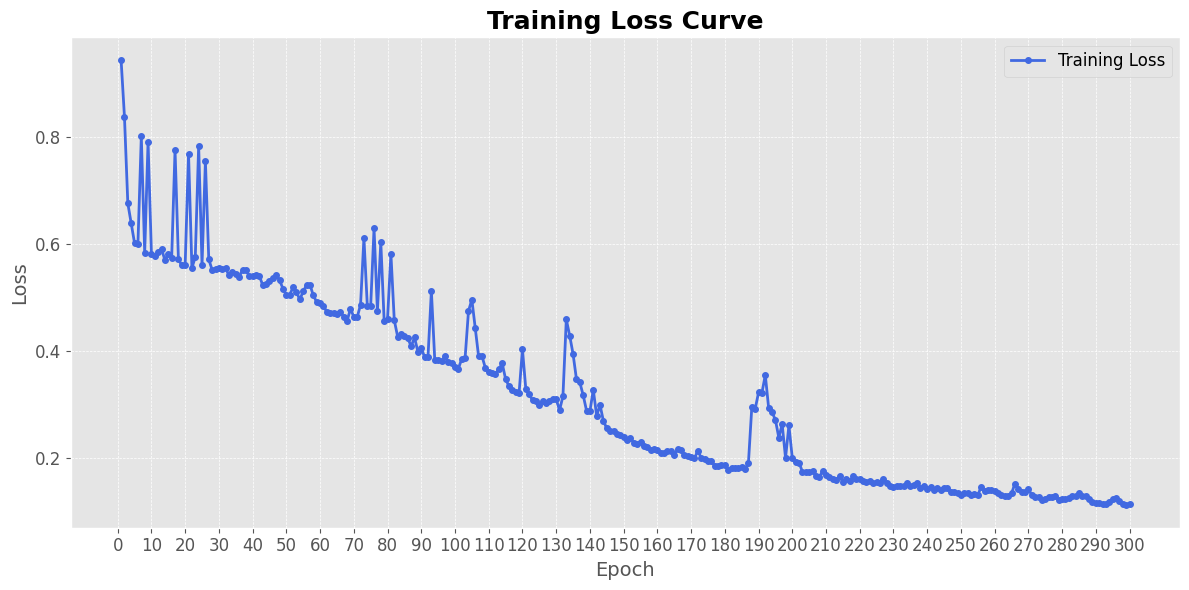

In [483]:
save_path="../images_model_training_and_eval/seq2seq_autoregressive_LSTM_loss_training_curve.png"

plot_loss_curve(loss_storage,save_path=save_path)  

## Model Evaluation

### Define evaluation model function

In [484]:
def evaluate_model(model, dataloader, seed_value):
    model.eval()
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.to(device)
    outputs = outputs.to(device)

    inputs_seq = inputs.permute(1, 0, 2)
    outputs_seq = outputs.permute(1, 0, 2)

    pred = model(inputs_seq)

    true_vals = outputs_seq.cpu().numpy()[:, 0, :]
    pred_vals = pred.detach().cpu().numpy()[:, 0, :]

    print("Ground truth:\n", true_vals.T)
    print("Prediction:\n", pred_vals.T)
    print("MAE:", np.mean(np.abs(true_vals - pred_vals)))

    feature_mae = np.mean(np.abs(true_vals - pred_vals), axis=(0, 1))
    print("Feature-wise MAE:", feature_mae)

In [485]:
seed_value=187

evaluate_model(seq2seq_model,test_dataloader,seed_value)

Ground truth:
 [[-1.2752299  -1.3943083  -1.1437798  -1.3417282  -0.9247994  -0.93411076
  -1.1712726 ]
 [ 0.9080867   1.0646194   0.3442977   1.0381919   1.0034971   1.0053803
   0.53042036]
 [-0.47729036 -0.37316027 -0.82754606 -1.0846328   0.6615639   0.28450337
   0.49154565]
 [ 0.02438779  0.03548462  0.04330284  0.03674562  0.01828454  0.01723326
   0.027162  ]]
Prediction:
 [[-1.276817   -1.373256   -1.3507314  -1.2625637  -1.2280957  -1.3054624
  -1.4134874 ]
 [ 1.2281624   1.2269251   0.9274871   0.2901146  -0.2536759  -0.16359983
   0.06552557]
 [ 0.24343175  0.22298872  0.7978674   1.9305048   1.9881788   0.07561559
  -0.75978595]
 [ 0.5425839   0.38605028  0.2213034   0.08446831  0.00879377  0.07182479
   0.17731547]]
MAE: 0.57083184
Feature-wise MAE: 0.57083184


#### Define function to plot prediction versus ground truth 

In [486]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_some_predictions(model, dataloader, device, stats=None, indices=[2486, 2986]):
    feature_names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for features

    plt.style.use('ggplot')  
    model.eval()

    num_features = len(feature_names)
    num_samples = len(indices)
    
    fig, axs = plt.subplots(num_samples, num_features, figsize=(5 * num_features, 4 * num_samples))

    for row, seed in enumerate(indices):
        g = torch.Generator()
        g.manual_seed(seed)

        data_iter = iter(torch.utils.data.DataLoader(
            dataloader.dataset, batch_size=32, shuffle=True, generator=g
        ))

        inputs, outputs = next(data_iter)
        inputs, outputs = inputs.to(device), outputs.to(device)

        inputs_seq = inputs.permute(1, 0, 2)      # (T_in, B, F)
        outputs_seq = outputs.permute(1, 0, 2)    # (T_out, B, F)
        preds = model(inputs_seq)                # (T_out, B, F)

        b = 0  # first sample in the batch

        x = inputs[b].detach().cpu().numpy()         # (T_in, F)
        y_true = outputs_seq[:, b, :].detach().cpu().numpy()  # (T_out, F)
        y_pred = preds[:, b, :].detach().cpu().numpy()        # (T_out, F)

        # Denormalize if stats provided
        if stats is not None:
            for i, name in enumerate(feature_names):
                mean = stats.loc[name, 'mean']
                std = stats.loc[name, 'std']
                x[:, i] = x[:, i] * std + mean
                y_true[:, i] = y_true[:, i] * std + mean
                y_pred[:, i] = y_pred[:, i] * std + mean

        # Time steps
        t1 = list(range(x.shape[0]))  # input timesteps
        t3 = [x.shape[0] + i + 1 for i in range(y_true.shape[0])]  # prediction timesteps

        mse = np.mean((y_true - y_pred) ** 2)

        for col in range(num_features):
            ax = axs[row, col] if num_samples > 1 else axs[col]
            feature = feature_names[col]
            color = colors[col % len(colors)]

            # Plot input
            ax.plot(t1, x[:, col], linestyle='--', linewidth=2, label="Input", color=color)
            # Plot true values
            ax.scatter(t3, y_true[:, col], label="True", color=color, marker='o', s=50, edgecolors='black', linewidth=0.5)
            # Plot predictions
            ax.scatter(t3, y_pred[:, col], label="Pred", color='black', marker='x', s=60)

            ax.set_title(f"{feature} | seed={seed} | MSE={mse:.4f}", fontsize=11)
            ax.grid(True)

            if row == num_samples - 1:
                ax.set_xlabel("Timestep")
            if col == 0:
                ax.set_ylabel("Value")
            if row == 0:
                ax.legend(loc='upper center', fontsize=8)

    plt.tight_layout()
    plt.show()




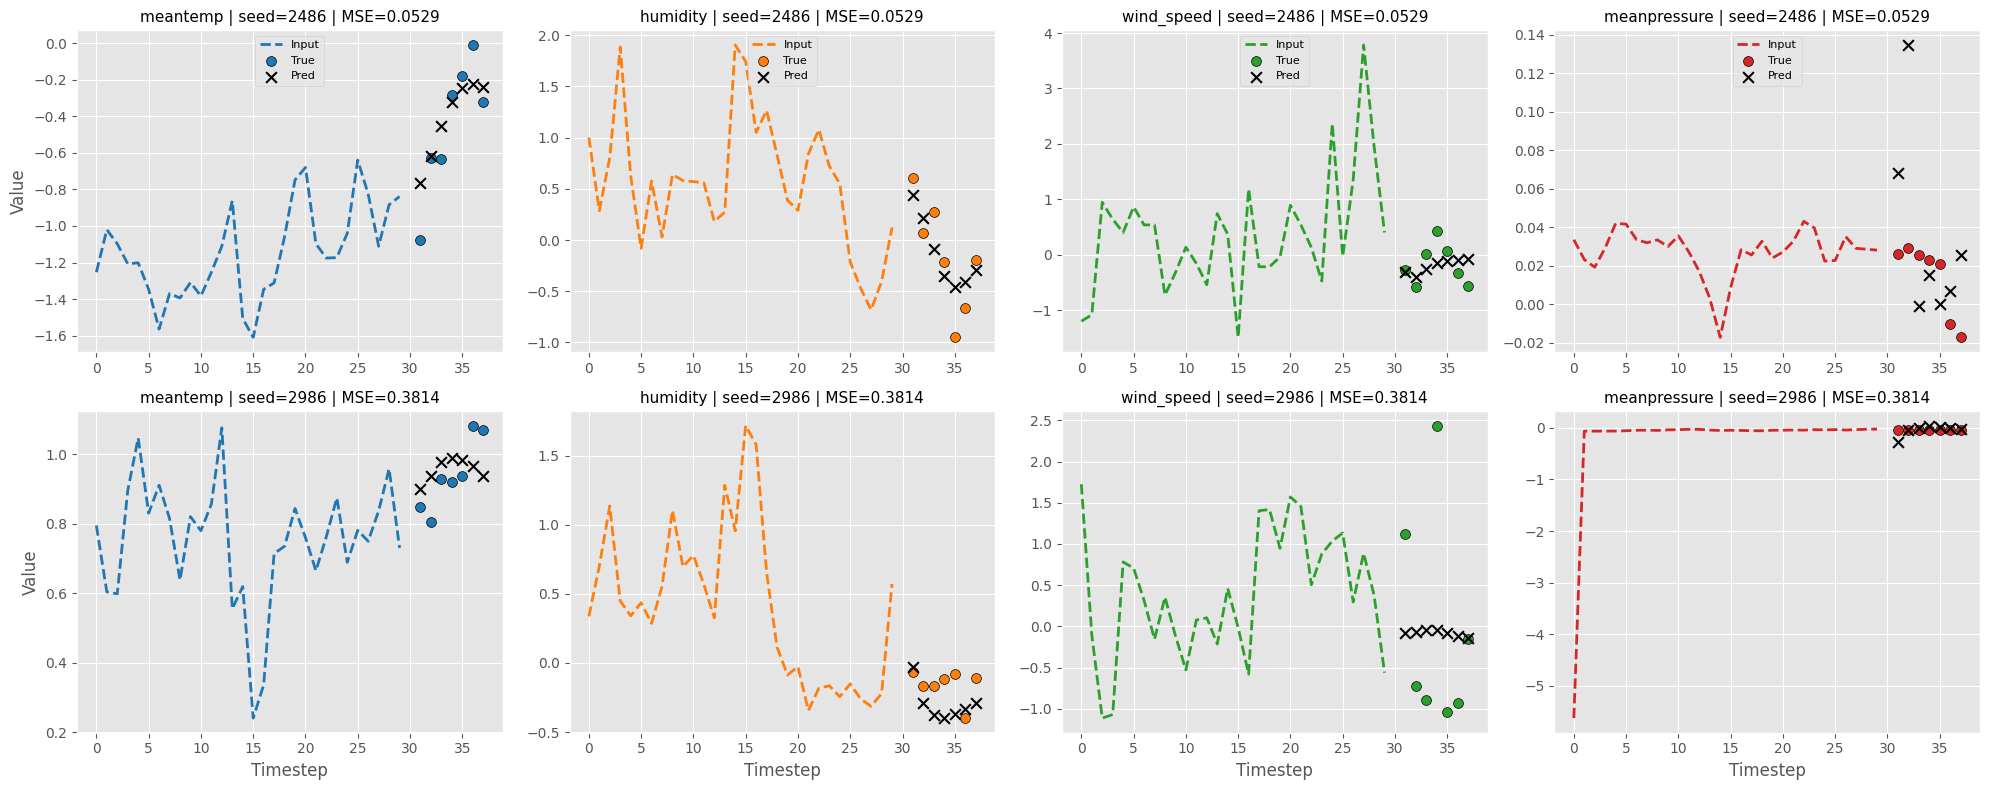

In [487]:
# Visualize
visualize_some_predictions(seq2seq_model, train_dataloader, device)